# Single A2A Example

This notebook demonstrates how to run a single Allocation-to-Allocators (A2A) job from the AlloOptim library.

## 1. Import Libraries

Import the necessary libraries for A2A optimization.

In [ ]:
import numpy as np
import pandas as pd

from allooptim.allocation_to_allocators.orchestrator_factory import (
    create_orchestrator,
    OrchestratorType,
)
from allooptim.config.a2a_config import A2AConfig
from allooptim.config.stock_universe import list_of_dax_stocks
from allooptim.allocation_to_allocators.data_provider_factory import (
    get_data_provider_factory,
)

print("Libraries imported successfully!")

INFO:allooptim:AlloOptim package initialized successfully


Libraries imported successfully!


## 2. Create Sample Portfolio Data

Create sample price data for a portfolio of assets.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Get sample stocks (using first 5 DAX stocks)
all_stocks = list_of_dax_stocks()[:5]
assets = [stock.symbol for stock in all_stocks]

# Generate 6 months of daily price data
dates = pd.date_range("2023-01-01", periods=126, freq="D")
n_assets = len(assets)

# Generate correlated price movements
returns = np.random.multivariate_normal(
    mean=np.full(n_assets, 0.0005),  # 0.05% daily return
    cov=np.eye(n_assets) * 0.0004 + np.full((n_assets, n_assets), 0.0001),  # Some correlation
    size=len(dates),
)

# Create price DataFrame
prices = pd.DataFrame(
    100 * np.exp(np.cumsum(returns, axis=0)),
    index=dates,
    columns=assets
)

print("Sample Data Created:")
print(f"Assets: {', '.join(assets)}")
print(f"Date range: {dates[0].date()} to {dates[-1].date()}")
print(f"Price data shape: {prices.shape}")
print(f"\nSample prices (first 3 rows):")
print(prices.head(3))

Sample Data Created:
Assets: ADS.DE, ALV.DE, BAS.DE, BAYN.DE, BMW.DE
Date range: 2023-01-01 to 2023-05-06
Price data shape: (126, 5)

Sample prices (first 3 rows):
                ADS.DE      ALV.DE     BAS.DE     BAYN.DE      BMW.DE
2023-01-01  100.543681   98.545477  96.921195  100.002784  100.970024
2023-01-02  102.305337  101.271231  96.866751   97.942955  100.459127
2023-01-03  103.441640  101.822707  99.210447  100.935692   96.820240


## 3. Run A2A Optimization

Initialize and run the Allocation-to-Allocators optimization with equal weighting.

In [3]:
# Configure A2A with diverse optimizers
optimizer_names = ["MaxSharpe", "RiskParityOptimizer", "NaiveOptimizer"]

# Create A2A configuration for optimized orchestration
config = A2AConfig(
    n_simulations=50,  # MCOS simulation iterations
    n_pso_iterations=200,  # PSO optimization iterations
    n_particles=30,  # Particle swarm size
)

# Create optimized orchestrator using factory pattern
orchestrator = create_orchestrator(
    orchestrator_type=OrchestratorType.OPTIMIZED,
    optimizer_names=optimizer_names,
    transformer_names=["OracleCovarianceTransformer"],
    config=config,
)

print("A2A Configuration:")
print(f"  Optimizers: {', '.join(optimizer_names)}")
print(f"  Type: {OrchestratorType.OPTIMIZED}")
print(f"  MCOS Simulations: {config.n_simulations}")
print(f"  PSO Iterations: {config.n_pso_iterations}")

# Create data provider for backtest context
data_provider_factory = get_data_provider_factory("backtest")
data_provider = data_provider_factory.create_data_provider(prices)

# Run A2A optimization
print("\n🚀 Running A2A optimization...")
result = orchestrator.allocate(
    data_provider=data_provider,
    time_today=dates[-1],
    all_stocks=all_stocks,
)

print(f"\n✅ Success: True")  # A2AResult doesn't have a success field like the old result

A2A Configuration:
  Optimizers: MaxSharpe, RiskParityOptimizer, NaiveOptimizer
  Type: OrchestratorType.OPTIMIZED
  MCOS Simulations: 50
  PSO Iterations: 200

🚀 Running A2A optimization...


2025-11-06 06:18:30,787 - allooptim.allocation_to_allocators.optimized_orchestrator - INFO - Computing allocation for NaiveOptimizer...
2025-11-06 06:18:30,803 - allooptim.allocation_to_allocators.optimized_orchestrator - INFO - Computing allocation for RiskParityOptimizer...
2025-11-06 06:18:30,830 - allooptim.allocation_to_allocators.optimized_orchestrator - INFO - Computing allocation for MaxSharpe...



✅ Success: True


## 4. Display Results

Show the final portfolio allocation and optimizer weights.

Final Portfolio Allocation:
----------------------------------------
BMW.DE: 0.2958 (29.58%)
ALV.DE: 0.2267 (22.67%)
BAYN.DE: 0.2248 (22.48%)
BAS.DE: 0.1304 (13.04%)
ADS.DE: 0.1224 (12.24%)

Total weight: 1.000000

Optimizer Weights:
----------------------------------------
NaiveOptimizer: 0.3996 (39.96%)
RiskParityOptimizer: 0.2126 (21.26%)
MaxSharpe: 0.3878 (38.78%)

Performance Metrics:
----------------------------------------
Expected Return: 0.0019
Volatility: 0.0001
Sharpe Ratio: 24.2502
Diversity Score: 1.3333


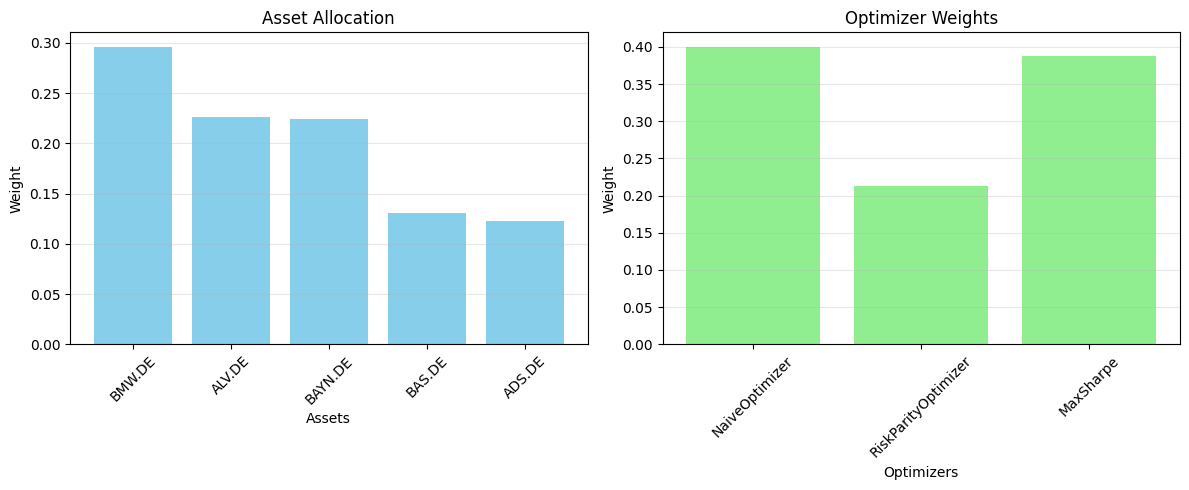

✅ A2A optimization completed successfully!


In [ ]:

# Display asset weights
print("Final Portfolio Allocation:")
print("-" * 40)
sorted_weights = sorted(result.final_allocation.items(), key=lambda x: x[1], reverse=True)
for asset, weight in sorted_weights:
    print(f"{asset}: {weight:.4f} ({weight*100:.2f}%)")

total_weight = result.final_allocation.sum()
print(f"\nTotal weight: {total_weight:.6f}")

# Display optimizer weights
optimizer_weights_series = result.get_optimizer_weights_series()
print(f"\nOptimizer Weights:")
print("-" * 40)
for optimizer, weight in optimizer_weights_series.items():
    print(f"{optimizer}: {weight:.4f} ({weight*100:.2f}%)")

# Display performance metrics
print(f"\nPerformance Metrics:")
print("-" * 40)
print(f"Expected Return: {result.metrics.expected_return:.4f}")
print(f"Volatility: {result.metrics.volatility:.4f}")
print(f"Sharpe Ratio: {result.metrics.sharpe_ratio:.4f}")
print(f"Diversity Score: {result.metrics.diversity_score:.4f}")

try:
    import matplotlib as plt
except ImportError:
    print("Matplotlib not installed, skipping visualization.")
    exit(0)

# Create visualization
plt.figure(figsize=(12, 5))

# Asset allocation bar chart
plt.subplot(1, 2, 1)
assets_list = [asset for asset, _ in sorted_weights]
weights_list = [weight for _, weight in sorted_weights]
plt.bar(assets_list, weights_list, color='skyblue')
plt.title('Asset Allocation')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Optimizer weights bar chart
plt.subplot(1, 2, 2)
optimizers = list(optimizer_weights_series.index)
opt_weights = list(optimizer_weights_series.values)
plt.bar(optimizers, opt_weights, color='lightgreen')
plt.title('Optimizer Weights')
plt.xlabel('Optimizers')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ A2A optimization completed successfully!")